## PHY307 - data analysis exercise

In this exercise we will analyze data recorded by the Compact muon Solenoid (CMS) experiment at the Large Hadron Collider (LHC).
In 2012, after two years of data taking, the ATLAS and CMS experiments reported the observation of a new particle with a mass around 125 GeV, later established to be the Higgs boson. The Higgs boson, when produced in a high energy collision, decays almost immediately into other particles. One of the main decay channels used to establish the existence of the Higgs boson is the decay to a pair of Z bosons, which themselves decay to pairs of electrons or muons. This is a very clean signature, and one can see the visible peak in the four-lepton invariant mass distribution caused by the Higgs boson:

<center><img src="CMS-HIG-13-002_Figure_010.png" width="500"></center>

This plot has a few key features that we will aim to reproduce:

 - The actual data is shown by the black markers - each point corresponds to the number of events observed with invariant mass in the given bin
 - The solid histograms are our expectation, derived using simulated events ("Monte Carlo simulation").
 - There are three histograms, stacked on top of each other, corresponding to three processes:
   - In green, Z+X, the production of a single Z boson plus possible additional hadronic jets. This is a small background, and we will neglect it in this exercise.
   - In blue, the ZZ background - this includes all the Feynman diagrams with the production of two Z bosons without involving the Higgs boson - this is going to be the main background process to our signal.
   - In red, the Higgs boson signal according to the standard model predictions for a Higgs boson with a mass of 125 GeV.
  
An example Feynman diagram for the signal, and two possible diagrams for the ZZ background are given below:


<center><img src="FeynSig.png" width="310"><img src="FeynBkg1.png" width="220"><img src="FeynBkg2.png" width="200"></center>

As we will see, the ZZ background is not the only one we have to worry about. It covers the contribution where all four leptons are what we call "prompt" - i.e. produced in isolation from the decay of a vector boson. There will also be a contribution from events with "non-prompt" leptons, either mis-identified "fake" leptons, or real leptons produced from semi-leptonic meson decays within "jets" of hadronic particles.

*Throughout this notebook there are several places where you will need to answer questions, e.g. below:*

Name: 

We might first wonder why we choose to look at the Higgs boson decay to ZZ. The figure below shows the predicted Higgs boson branching fractions as a function of $m_{H}$. What is the approximate branching fraction for $H\rightarrow ZZ$ at $m_{H} = 125\,\mathrm{GeV}$? Why is this still a preferable decay channel to look at, say compared to $H\rightarrow bb$, which has the largest branching fraction at around 60%?

<center><img src="Higgs_BR_LM.png" width="500"></center>

Answer:

### A first look at the files

Lets get started with some analysis. In this exercise we will focus on the case where both Z bosons decay to a pair of muons. The real data is containing in two files: `Run2012B_DoubleMuParked.root`, and `Run2012C_DoubleMuParked.root`. The simulated Higgs boson signal is in `SMHiggsToZZto4L.root`, and the simulated ZZ background is in `ZZTo4mu.root`. Start running the cells below to take a look into the structure of the signal file.

In [1]:
# We start by importing some modules:
import uproot  # reads the data in the binary .root files
import awkward as ak  # provides "ragged" arrays for n-dimensional arrays with variables lengths
import vector  # defines classes for manipulating, e.g. four-vectors
import boost_histogram as bh # for filling hisograms
import matplotlib.pyplot as plt  # for visualising histograms and other plots
import numpy as np 
import numba # "just-in-time" compiling of complex functions
import mplhep as hep
plt.rcParams['figure.dpi'] = 100

In [2]:
# We load a data structure called a "Tree" into memory. We can think of this as set of labelled 2D arrays.
# The rows correspond to separate proton-proton collision events, and the columns contain information about different objects in 
# each event, e.g. the properties of the reconstructed muons. Because there can be a variable number of objects per event,
# many of the arrays are special "jagged" arrays.
events = uproot.open("SMHiggsToZZTo4L.root:Events")
# First let's see a summary data stored in the tree
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

In [3]:
# Now let's read the data from the file
branches = events.arrays()

# We can look at the data for a single branch, the number of reconstructed muons in each event
print(branches["nMuon"])

[3, 0, 0, 7, 0, 2, 1, 0, 0, 0, 1, 2, 0, ..., 0, 0, 0, 2, 2, 2, 0, 2, 2, 4, 0, 0]


In [4]:
# We see the first event had three muons, the second event had zero muons, etc.
# We can also look at the properties of those muons, for example their transverse momenta:
print(branches["Muon_pt"])

[[63, 38.1, 4.05], [], [], [54.3, ...], ..., [4.32, 4.36, 5.63, 4.75], [], []]


We can see the three muons in the first event have transverse momenta of 63, 38.1 and 4.05 GeV, respectively.
This is an example of a "jagged array" - a 2D array where there's a different number of entries in each row (reflecting the fact that there is a variable number of muons reconstructed in each event). Let's make a histogram of the muon pt for all muons in the sample.

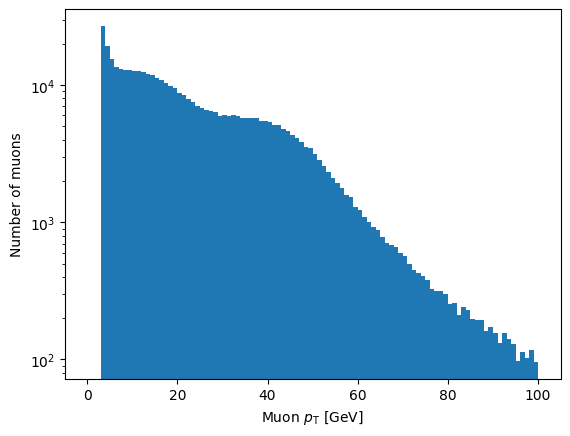

In [5]:
plt.hist(ak.flatten(branches["Muon_pt"]), bins=100, range=(0,100))
# Here we have to first "flatten" the jagged Muon_pt array, i.e. transform an array like:
# [ [1, 2], [3], [4, 5, 6] ] into [1, 2, 3, 4, 5, 6]
plt.xlabel('Muon $p_{\mathrm{T}}$ [GeV]')
plt.ylabel('Number of muons')
plt.yscale('log') # Some distributions will look better if we use a logarithmic y-axis scale
plt.show()

### Object kinematics

In our TTree we see that we have branches `Muon_pt`, `Muon_eta`, `Muon_phi` and `Muon_mass`. Together, these define the four-momenta for the muons. We use these variables instead of the usual $(E, p_{x}, p_{y}, p_{z})$ as they are more convenient for how we typically perform analysis. Here, eta is the pseudorapidity, and phi is the azimuthal angle, defined in the cylindrical geometry illustrated below:

<center><img src="coords.png" height="200"><img src="eta.png" height="200"></center>

The pseudorapidity ($\eta$) is related to the polar angle defined with respect to the z-axis (the beam axis), as

$$
\eta = -\ln\left[\tan\left(\frac{\theta}{2}\right)\right]
$$

which is illustrated in the above figure. The beams of colliding protons travel along the z-axis from the negative and positive directions, and collide at the origin of the coordinate system, at the center of the CMS detector (IP).

Using the code for plotting the pT above as a template, write code in the next two cells to plot the muon pseudorapidity (eta) and azimuthal angle (phi). Plot these in linear y-axis scale.

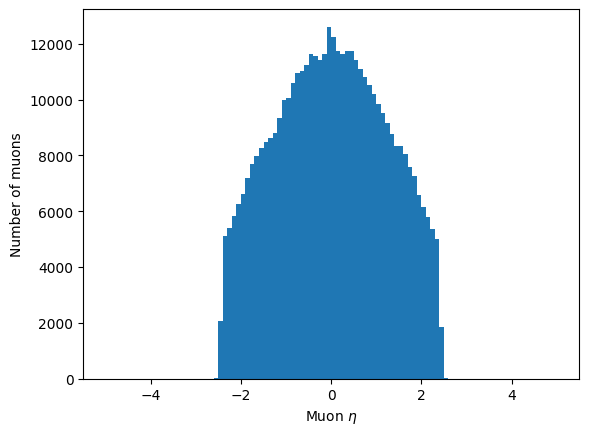

In [6]:
# Plot the muon eta here, use a range of -5, 5

### DELETE THIS PART
plt.hist(ak.flatten(branches["Muon_eta"]), bins=100, range=(-5,5))
plt.xlabel('Muon $\eta$')
plt.ylabel('Number of muons')
plt.show()
### DELETE THIS PART

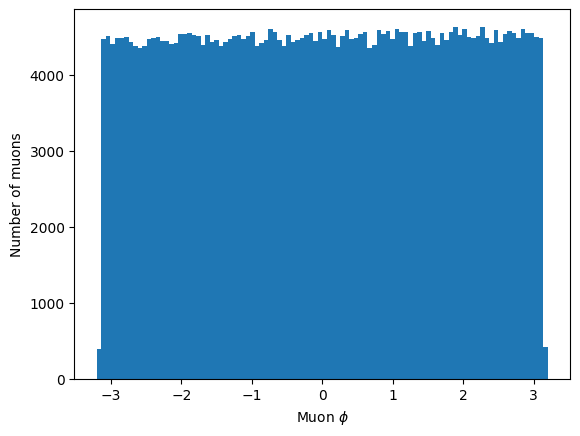

In [7]:
# Plot the muon phi here, use a range of -3.2,3.2

### DELETE THIS PART
plt.hist(ak.flatten(branches["Muon_phi"]), bins=100, range=(-3.2,3.2))
plt.xlabel('Muon $\phi$')
plt.ylabel('Number of muons')
plt.show()
### DELETE THIS PART

Questions:

 1) Considering the symmetries of the collision system, comment qualitatively on why one of these distributions is flat, and the other is not (but is approximately symmetric about zero)
 2) You should find the eta distribution stops suddenly at particular values. By considering the layout of the detector (see figure below), comment on why this might be the case.

<center><img src="detector.jpg" height="400"></center>
 

Answers:

 1. 

 2.

### Invariant mass

Given we are looking for evidence of a new particle decaying to four muons, it isn't surprising that the invariant mass of the four-muon system will be a particularly powerful discriminator. Given the pt, eta, phi and mass of each muon, you could code up some formulae to convert these to (E, px, py, pz) vectors, then perform a sum over the muons to give the four-momentum of the system, from which you could calculate the invariant mass. This would be rather tedious, however, so instead we will make use of the `vector` module we imported earlier, to group the (pt,eta,phi,mass) variables into four-momentum objects that give us a lot of useful functions, and the ability to do things like add two vectors together.

[{rho: 57.6, phi: 0.999, eta: -1.88, tau: 125}, ..., {rho: 19.2, phi: ..., ...}]
[{rho: 67.7, phi: 1.43, eta: 0.834, tau: 99}, ..., {rho: 18.5, phi: 0.892, ...}]
False


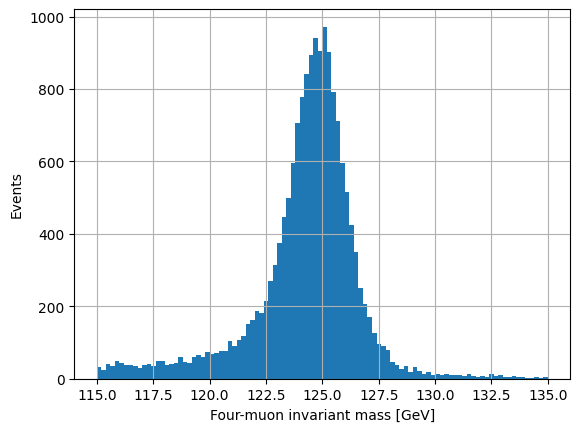

'\n# We\'ll structure this as a function so we can reuse it later\ndef CalculateFourMuonMass(samples):\n\n    # In preparation for later code, we won\'t fill the histogram in one go, as we\'ll need to process\n    # rows (events) in batches. So first we define an empty histogram, with 100 bins from 115 to 135 GeV.\n    hist = bh.Histogram(bh.axis.Regular(100, 115, 135))\n\n    # We loop through the input files buffering up to 10 MB of events at a time\n    for branches in uproot.iterate(samples, step_size="10 MB", filter_name=["Muon*"]):\n        # Construct the four-momentum objects\n        muons = ak.zip({\n            "pt": branches["Muon_pt"],\n            "eta": branches["Muon_eta"],\n            "phi": branches["Muon_phi"],\n            "mass": branches["Muon_mass"]\n            }, with_name="Momentum4D")\n        # muons is now an awkward array of four-momentum objects\n\n        # Filter out rows (events) that don\'t have exactly four muon objects\n        four_muon_events = m

In [11]:
# Special command that will allow merging the pt,eta,phi,mass branches into a four-vector object
vector.register_awkward()

### DELETE THIS PART
# We'll structure this as a function so we can reuse it later
def CalculateFourMuonMass(samples, bins, xmin, xmax, logscale=False):

    # In preparation for later code, we won't fill the histogram in one go, as we'll need to process
    # rows (events) in batches. So first we define an empty histogram, with the binning specified by the user.
    hist = bh.Histogram(bh.axis.Regular(bins, xmin, xmax))

    # We loop through the input files buffering up to 10 MB of events at a time
    for branches in uproot.iterate(samples, step_size="10 MB", filter_name=["Muon*"]):
        # Construct the four-momentum objects
        muons = ak.zip({
            "pt": branches["Muon_pt"],
            "eta": branches["Muon_eta"],
            "phi": branches["Muon_phi"],
            "mass": branches["Muon_mass"]
            }, with_name="Momentum4D")
        # muons is now an awkward array of four-momentum objects

        # Filter out rows (events) that don't have exactly four muon objects
        four_muon_events = muons[(ak.num(muons) == 4)]

        # Now we sum over the four muons in the remaining events
        # Remember, four_muon_events is a 2D array, and we want to operate on all rows, and select specific columns (muons)
        # Therefore we use [rows, columns] = [:, 0] to select all events and the first muon
        four_muon_system = four_muon_events[:, 0] + four_muon_events[:, 1] + four_muon_events[:, 2] + four_muon_events[:, 3]

        # The four_muon_system is now a single four-vector object per event
        print(four_muon_system)

        hist.fill(four_muon_system.mass)

    hep.histplot(hist, histtype="fill", flow="none")
    plt.xlabel('Four-muon invariant mass [GeV]')
    plt.ylabel('Events')
    plt.grid(which="both")
    print(logscale)
    if logscale:
        plt.yscale('log')
    plt.show()

CalculateFourMuonMass(["SMHiggsToZZTo4L.root:Events"], 100, 115, 135)
### DELETE THIS PART

"""
# We'll structure this as a function so we can reuse it later
def CalculateFourMuonMass(samples):

    # In preparation for later code, we won't fill the histogram in one go, as we'll need to process
    # rows (events) in batches. So first we define an empty histogram, with 100 bins from 115 to 135 GeV.
    hist = bh.Histogram(bh.axis.Regular(100, 115, 135))

    # We loop through the input files buffering up to 10 MB of events at a time
    for branches in uproot.iterate(samples, step_size="10 MB", filter_name=["Muon*"]):
        # Construct the four-momentum objects
        muons = ak.zip({
            "pt": branches["Muon_pt"],
            "eta": branches["Muon_eta"],
            "phi": branches["Muon_phi"],
            "mass": branches["Muon_mass"]
            }, with_name="Momentum4D")
        # muons is now an awkward array of four-momentum objects

        # Filter out rows (events) that don't have exactly four muon objects
        four_muon_events = muons[(ak.num(muons) == 4)]

        # Now we sum over the four muons in the remaining events
        # Remember, four_muon_events is a 2D array, and we want to operate on all rows, and select specific columns (muons)
        # Therefore we use [rows, columns] = [:, 0] to select all events and the first muon
        four_muon_system = four_muon_events[:, 0] + four_muon_events[:, 1] + four_muon_events[:, 2] + four_muon_events[:, 3]

        # The four_muon_system is now a single four-vector object per event
        print(four_muon_system)

        hist.fill(four_muon_system.mass)

    hep.histplot(hist, histtype="fill", flow="none")
    plt.xlabel('Four-muon invariant mass [GeV]')
    plt.ylabel('Events')
    plt.show()

CalculateFourMuonMass(["SMHiggsToZZTo4L.root:Events"])
"""

Questions:

 1) Is the shape of the distribution as you expected?
 2) The Higgs boson, if produced, is predicted to decay extremely quickly, with a lifetime $\tau = 1.56\times 10^{-22}\,\mathrm{s}$. Given $\hbar = 6.58 \times 10^-16\,\mathrm{eV\,s^{-1}}$, calculate the natural width in MeV.
 3) What value do you get for the width estimated from the plot above (i.e. the width of the mass peak at half maximum). Note that adding `plt.grid(which="both")` may help with this!
 4) Comment on the difference between the two. What could be the reason for this? Could we use this analysis to test whether the Higgs boosn width is as predicted in the standard model?

 Bonus questions (finish everything else first!)

 5) You will notice that the peak above is asymmetric, with a larger lower tail. What might be the origin of this "missing mass"?
 6) Why is it important to try and constrain the Higgs boson width experimentally, i.e. what could it mean if we measured a value higher than expected?

Answers:

1.

2.

3.

4.

Bonus:

5.

6.

Now make the invariant mass plot for the background, using `ZZTo4mu.root`. This time, use 100 bins and a range from 0 to 200 GeV, and use a logarithmic y-axis scale. To do this, you could add input arguments to the `CalculateFourMuonMass` function above that allow the caller to specify the binning and whether or not log scale is used.

[{rho: 48.9, phi: 1.55, eta: 0.914, tau: 235}, ..., {rho: 14.3, phi: 1.6, ...}]
[{rho: 49.7, phi: -1.23, eta: 1.85, tau: 226}, ..., {rho: 2.09, phi: ..., ...}]
[{rho: 26.8, phi: -0.0548, eta: 0.385, tau: 92}, {...}, ..., {rho: 4.75, ...}]
[{rho: 34.7, phi: -0.751, eta: -2.38, tau: 85.8}, {...}, ..., {rho: 19.6, ...}]
[{rho: 38.5, phi: 2.63, eta: 2.41, tau: 89.7}, ..., {rho: 4.09, phi: 2.4, ...}]
[{rho: 7.97, phi: 1.29, eta: -0.0687, tau: 106}, {...}, ..., {rho: 3.68, ...}]
[{rho: 0.683, phi: -0.664, eta: 3.73, tau: 89.2}, {...}, ..., {rho: 57.7, ...}]
[{rho: 5.28, phi: -0.937, eta: -2.65, tau: 102}, {...}, ..., {rho: 18.5, ...}]
[{rho: 29.8, phi: 0.0108, eta: 1.63, tau: 90.2}, ..., {rho: 32, phi: 0.54, ...}]
[{rho: 50.1, phi: 0.429, eta: 0.173, tau: 149}, ..., {rho: 26.4, phi: ..., ...}]
[{rho: 25.7, phi: -0.728, eta: 1.73, tau: 85.6}, ..., {rho: 23, phi: 1.33, ...}]
[{rho: 24.1, phi: 2.45, eta: 3.19, tau: 201}, ..., {rho: 15.9, phi: -0.84, ...}]
[{rho: 14.6, phi: -0.279, eta: -1.3, ta

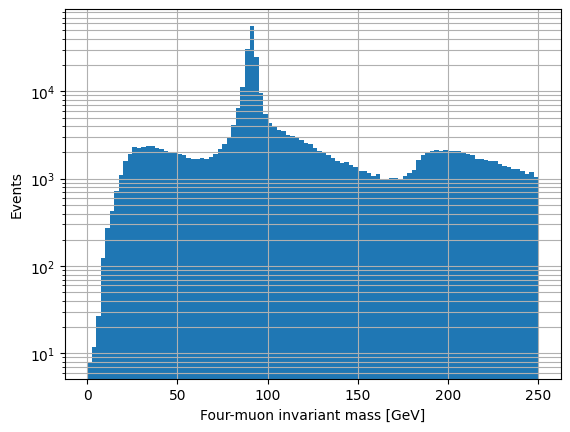

In [12]:
### DELETE THIS PART
CalculateFourMuonMass("ZZTo4Mu.root:Events", 100, 0, 250, logscale=True)
### DELETE THIS PART

# Extend the function above to take arguments for: the number of bins, the start of the range, the
# end of the range, and a flag to toggle the use of the log-y scale
# CalculateFourMuonMass("ZZTo4Mu.root:Events", ...)

Question: This plot shows a lot of different features. Try to explain, qualitatively, as much as you can. For example, you should see a large peak at a certain mass value (think about the Feynman diagrams at the top of this notebook). Also consider whether one (or both) Z bosons are on mass shell (i.e. where $m_{\mu\mu} \approx m_{Z}$).

Answer:

### Full $H\rightarrow ZZ \rightarrow 4\mu$ reconstruction

We are now ready to perform a full analysis. We will evaluate the four-muon invariant mass distribution for data, signal simulation and background simulation, and compare them on the same plot. We could just use the function defined above, but we can do better by first making sure the events we select are compatible with what we expect for the Higgs boson decay. 

We know there have to be four muons in total, but we also know that among these there should be two $\mu^{+}\mu^{-}$ pairs. We also know each pair should come from a Z boson - one pair from a Z boson that should be approximately on-shell, and one pair that has to be off-shell, with lower mass.

The code below is a bit more sophisticated - it will build all possible opposite-charge muon pairs, and find the permutation that gives a pair with mass closest to $m_{Z}$, labelling this $Z1$, with the other pair labelled $Z2$. It will then fill three histograms, one with the four-muon mass, and two with the Z1 and Z2 pair masses.

In [13]:

@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons, lep_charge in zip(events_leptons, events_leptons.charge):
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if lep_charge[i0] + lep_charge[i1] != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if lep_charge[i2] + lep_charge[i3] != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder

vector.register_awkward()

def RunSamples(samples, apply_muon_id=False, apply_Z_mass=False, z1range=(0,10000), z2range=(0,10000)):
    print("Running samples {}".format(samples))
    hists = {
        "m4l": bh.Histogram(bh.axis.Regular(36, 70, 180)),
        "mz1": bh.Histogram(bh.axis.Regular(40, 0, 160)),
        "mz2": bh.Histogram(bh.axis.Regular(40, 0, 160)),
        "iso":  bh.Histogram(bh.axis.Regular(60, 0, 5))
    }

    for branches in uproot.iterate(samples, step_size="10 MB", filter_name=["Muon*","event"]):
        branches = branches[ak.num(branches["Muon_pt"]) == 4]

        muons = ak.zip({
            "pt": branches["Muon_pt"],
            "eta": branches["Muon_eta"],
            "phi": branches["Muon_phi"],
            "mass": branches["Muon_mass"],
            "charge": branches["Muon_charge"],
            "pfRelIso04_all": branches["Muon_pfRelIso04_all"],
            "dxy": branches["Muon_dxy"],
            "dz": branches["Muon_dz"],
            "dxyErr": branches["Muon_dxyErr"],
            "dzErr": branches["Muon_dzErr"]
            }, with_name="Momentum4D")

        muons["ip3d"] = np.sqrt(muons.dxy * muons.dxy + muons.dz * muons.dz)
        muons["sip3d"] = muons.ip3d / np.sqrt(muons.dxyErr * muons.dxyErr + muons.dzErr * muons.dzErr)
        if apply_muon_id:
            muon_selection = (
                    (muons.pt > 5) & (np.abs(muons.eta) < 2.4) & 
                    (np.abs(muons.pfRelIso04_all) < 0.4) & 
                    (muons.sip3d < 4) & (np.abs(muons.dxy) < 0.5) & (np.abs(muons.dz) < 1.0)
                    )
        else:
            muon_selection = ((muons.pt > 5) & (np.abs(muons.eta) < 2.4))
            
        muons = muons[muon_selection]

        hists["iso"].fill(ak.flatten(muons.pfRelIso04_all))

        muon_counts = (ak.num(muons) == 4) & (ak.num(muons[muons.charge == 1]) == 2) & (ak.num(muons[muons.charge == -1]) == 2)
        muons = muons[muon_counts]

        if (len(muons) == 0):
            continue

        fourmuon = find_4lep(muons, ak.ArrayBuilder()).snapshot()
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })

        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])
        if apply_Z_mass:
            fourmuon_sel = (fourmuon.z1.p4.mass > z1range[0]) & (fourmuon.z1.p4.mass < z1range[1]) & (fourmuon.z2.p4.mass > z2range[0]) & (fourmuon.z2.p4.mass < z2range[1]) & (fourmuon.z1.lep1.deltaR(fourmuon.z1.lep2) > 0.02) & (fourmuon.z2.lep1.deltaR(fourmuon.z2.lep2) > 0.02)
        else:
            fourmuon_sel = (fourmuon.z1.lep1.deltaR(fourmuon.z1.lep2) > 0.02) & (fourmuon.z2.lep1.deltaR(fourmuon.z2.lep2) > 0.02)

        fourmuon = fourmuon[fourmuon_sel]

        hists["m4l"].fill((fourmuon.z1.p4 + fourmuon.z2.p4).mass)
        hists["mz1"].fill(fourmuon.z1.p4.mass)
        hists["mz2"].fill(fourmuon.z2.p4.mass)
    return hists

h_data = RunSamples(["Run2012B_DoubleMuParked.root:Events", "Run2012C_DoubleMuParked.root:Events"])
h_bkg = RunSamples(["ZZTo4mu.root:Events"])
h_sig = RunSamples(["SMHiggsToZZTo4L.root:Events"])

Running samples ['Run2012B_DoubleMuParked.root:Events', 'Run2012C_DoubleMuParked.root:Events']
Running samples ['ZZTo4mu.root:Events']
Running samples ['SMHiggsToZZTo4L.root:Events']


When the code above has finished running (it may take a few minutes), we can plot comparisons of $m_{Z1}$ and $m_{Z2}$ between data (which we assume is dominated by background events) and the signal simulation. The function in the next cell can make such a plot - it will normalize `hist1` and `hist2` to unit area, so that we compare just the shapes.

/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3534380542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3534380542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.sho

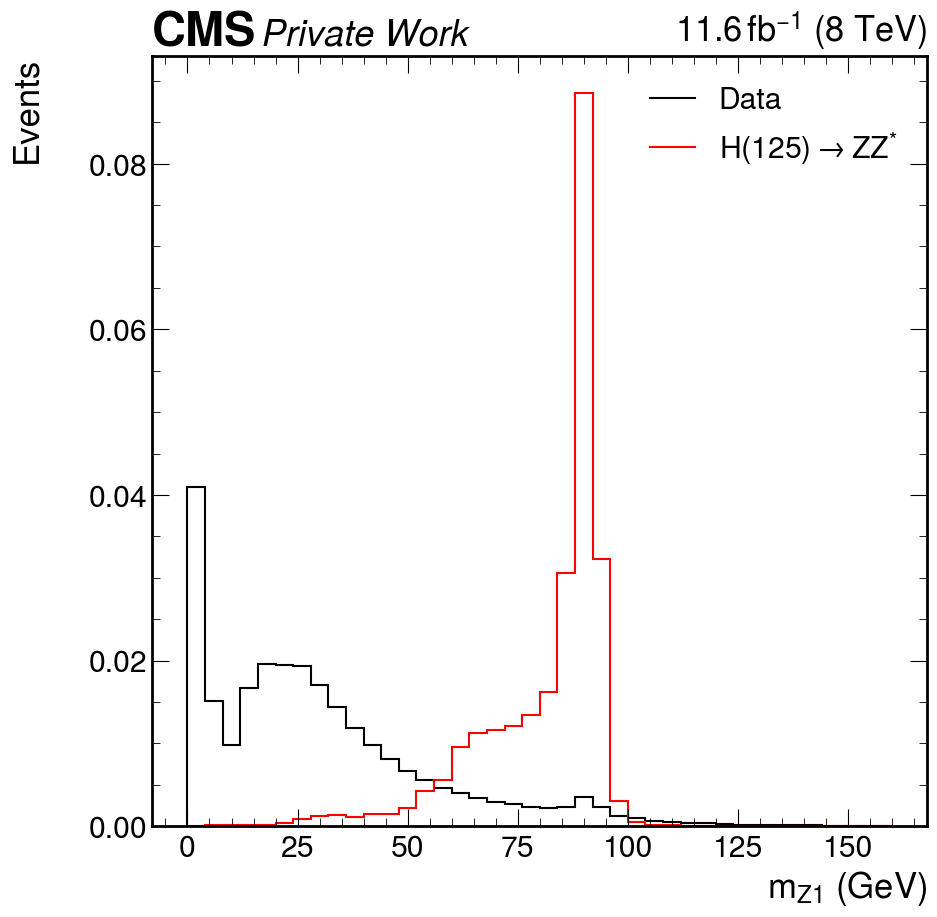

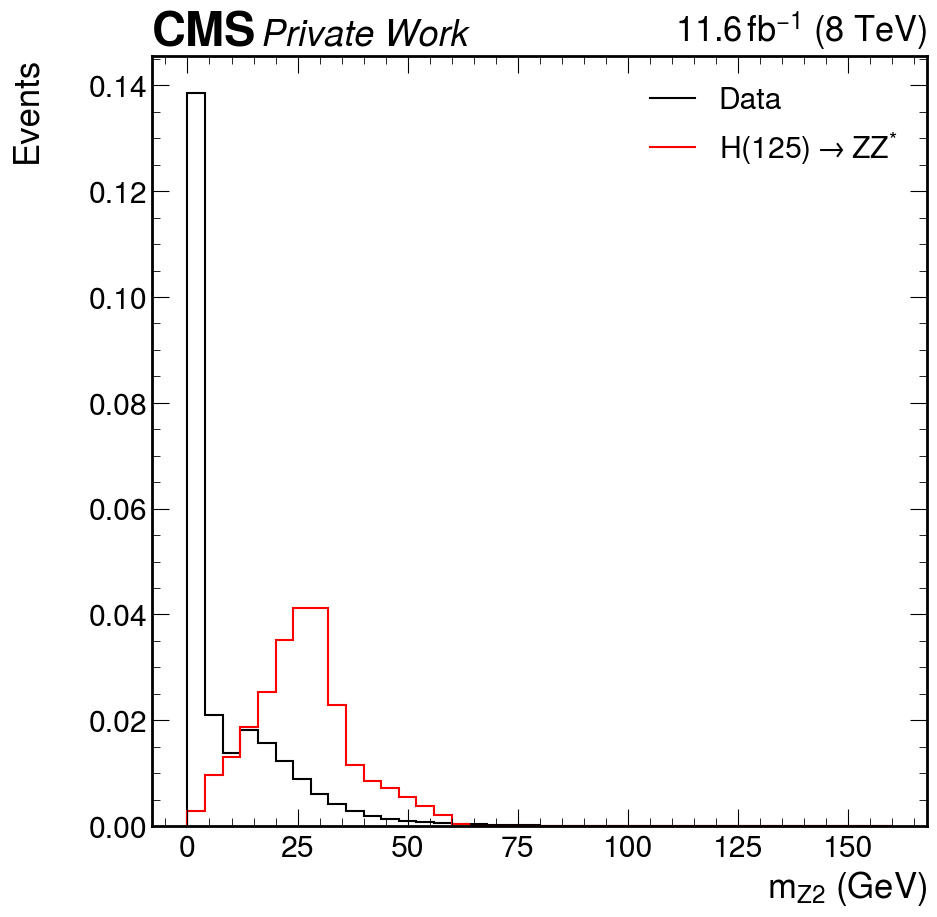

In [14]:
def PlotShapeComparison(hist1, hist2, label1, label2, xlabel):
    hep.style.use("CMS")
    fig, ax = plt.subplots()
    hep.histplot(
        [hist1 * (1. / hist1.sum()), hist2 * (1. / hist2.sum())],
        stack=False,
        histtype="step",
        color=["black", "red"],
        alpha=[1, 1],
        label=[label1, label2],
        ax=ax,
        flow="none",
        linestyle="solid",
        binwnorm=1
    )

    hep.cms.text("Private Work")
    hep.cms.lumitext(r"$11.6\,fb^{-1}$ (8 TeV)")
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel("Events\n", fontsize=25)
    fig.show()

PlotShapeComparison(h_data["mz1"], h_sig["mz1"], r"Data", r"H(125)$ \rightarrow ZZ^{*}$", r"$m_{Z1}$ (GeV)")
PlotShapeComparison(h_data["mz2"], h_sig["mz2"], r"Data", r"H(125)$ \rightarrow ZZ^{*}$", r"$m_{Z2}$ (GeV)")

You should have found that there are quite large differences between the data and signal distributions. This motivates adding selections ("cuts") on these variables, to improve the signal-to-background ratio. Below we will run the analysis again, this time adding upper and lower bounds on $m_{Z1}$ and $m_{Z2}$, that you should choose based on the plots above. The idea is to find values that are a good trade-off between maintaining a high signal efficiency while rejecting as much background as possible.

Running samples ['Run2012B_DoubleMuParked.root:Events', 'Run2012C_DoubleMuParked.root:Events']
Running samples ['ZZTo4mu.root:Events']
Running samples ['SMHiggsToZZTo4L.root:Events']


/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3534380542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3534380542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.sho

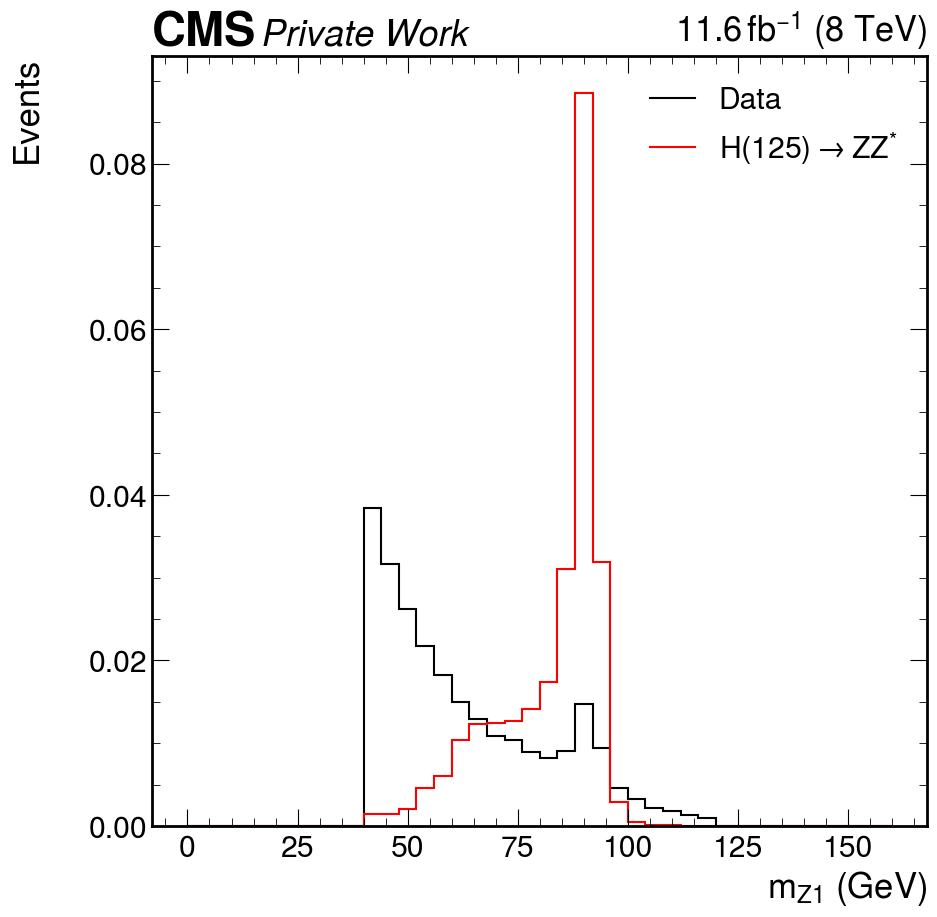

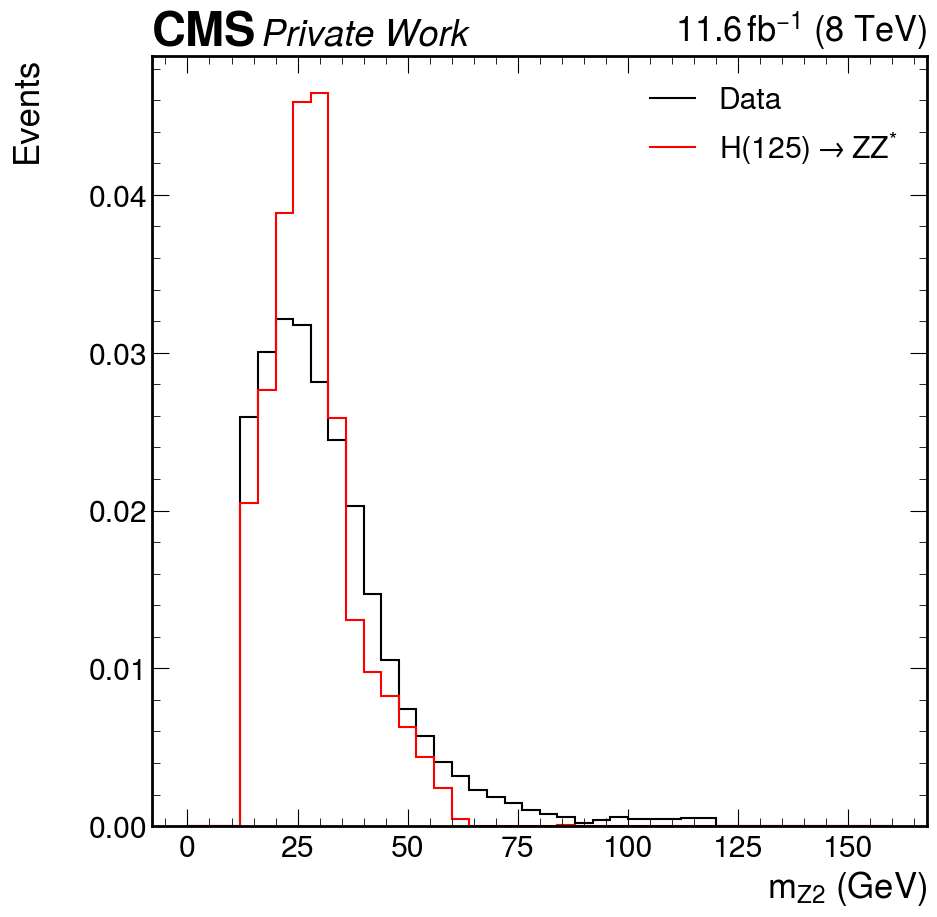

In [15]:
# Replace with your chosen values below
z1min = 0.
z1max = 10000.
z2min = 0.
z2max = 10000.

## DELETE THIS PART
z1min = 40.
z1max = 120.
z2min = 12.
z2max = 120.
## DELETE THIS PART

# Now we run the analysis again, adding the Z1 and Z2 mass cuts above
h_data = RunSamples(["Run2012B_DoubleMuParked.root:Events", "Run2012C_DoubleMuParked.root:Events"],
                    apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))
h_bkg = RunSamples(["ZZTo4mu.root:Events"],
                    apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))
h_sig = RunSamples(["SMHiggsToZZTo4L.root:Events"],
                    apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))

# Check that our cuts have the desired effect.
PlotShapeComparison(h_data["mz1"], h_sig["mz1"], r"Data", r"H(125)$ \rightarrow ZZ^{*}$", r"$m_{Z1}$ (GeV)")
PlotShapeComparison(h_data["mz2"], h_sig["mz2"], r"Data", r"H(125)$ \rightarrow ZZ^{*}$", r"$m_{Z2}$ (GeV)")

## Data/Simulation comparison

We're now nearly at the stage where we can compare data and simulation directly. What we need to do first is derive scaling factors for our signal and background histograms, such that they correspond to the number of events we expect in data. (Right now, their normalizations are arbitrary - the just depend on how many events we decided to generate). The number we use to quantify the "amount" of the data we have analyzed is called the integrated luminosity, $L$. If we know the cross section for a particular process, $\sigma$, then the number of events of that process we should see in the data is simply $N = L\sigma$. Given this, you should be able to complete the code below to calculate appropriate factors.

In [16]:
cross_section_bkg = 0.106722 # pb
num_events_bkg = 1499064.0
cross_section_sig = 0.0065 # pb
num_events_sig = 299973.0
lumi_data = 11.58 * 1000.0 # 11.58 fb-1 -> pb-1

# Modify the lines below to scale factors to apply to the signal and background histograms
# You want to calculate the ratio lumi_data / lumi_sample, where lumi_sample can be calculated from 
# the cross section for the process and the number of events that were generated
scale_factor_bkg = 1.
scale_factor_sig = 1.

## DELETE THIS
scale_factor_bkg = (lumi_data * cross_section_bkg) / num_events_bkg
scale_factor_sig = (lumi_data * cross_section_sig) / num_events_sig
## DELETE THIS

Once that's done, you can run the cell below to make a plot of the four-muon invariant mass. As you will hopefully see, we need to enable log-scale on the y-axis here. 

/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3046987690.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


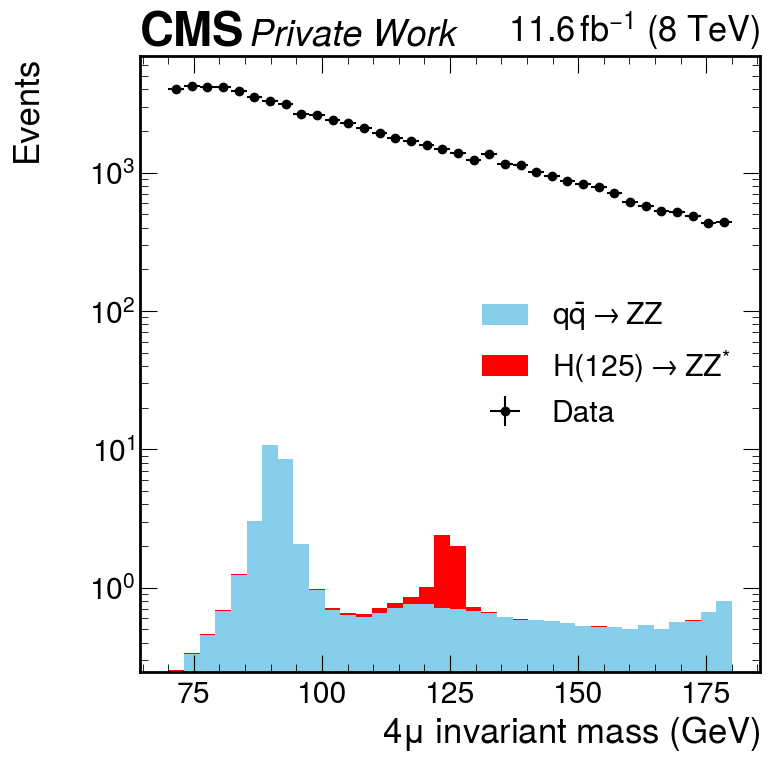

In [17]:
hep.style.use("CMS")

def PlotDataSimComparison(hist_data, hist_sig, hist_bkg, scale_sig=1.0, scale_bkg=1.0, logy=False):
   fig, ax = plt.subplots(figsize=(8,8))
   draw="m4l"
   hep.histplot(
      [hist_bkg * scale_bkg, hist_sig * scale_sig],
      stack=True,
      histtype="fill",
      color=["skyblue", "red"],
      alpha=[1, 1],
      label=[
         r"$q\bar{q}\rightarrow ZZ$",
         r"H(125)$ \rightarrow ZZ^{*}$",
      ],
      ax=ax,
      flow="none",
      linestyle="solid"
   )

   ax.errorbar(
      hist_data.axes[0].centers,
      hist_data.values(),
      xerr=hist_data.axes[0].widths / 2.,
      yerr=np.sqrt(hist_data.values()),
      linestyle="None",
      color="black",
      marker="o",
      label="Data"
   )
   hep.cms.text("Private Work")
   hep.cms.lumitext(r"$11.6\,fb^{-1}$ (8 TeV)")
   ax.legend()
   ax.set_xlabel(r"4$\mu$ invariant mass (GeV)", fontsize=25)
   ax.set_ylabel("Events\n", fontsize=25)
   if logy:
      plt.yscale('log')
   fig.show()

PlotDataSimComparison(h_data["m4l"], h_sig["m4l"], h_bkg["m4l"], scale_sig=scale_factor_sig, scale_bkg=scale_factor_bkg, logy=True)

You should see that the data is significantly higher than both the signal and background. As hinted at the start, there is another source of background for which we don't have a sample of simulated events. These are events where the muons are non-prompt. The proton-proton collisions of the LHC are extremely dominated by strong force interactions, and collisions producing jets of particles from the hadronization of quarks and gluons occur at a much higher rate than electroweak processes such as Higgs boson and ZZ production. What we are seeing here are mostly muons being produced from the semi-leptonic decays of mesons within these jets. Luckily, we have have a way of mostly removing this background: isolation. A key difference is that these muons are typically accompanied by other nearby particles in the jet, as in the sketch below. 

<center><img src="iso.png" width="300" ></center>

We can use an isolation variable computed as the sum of energy close to the muon, divided by its pT. The resulting value should be close to zero for a prompt isolated muon, and larger for non-prompt background muons. Let's compare the shapes of this variable.

/Users/Andrew/Code/PHY307-HandsOn/.venv/lib/python3.9/site-packages/mplhep/utils.py:240: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3534380542.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


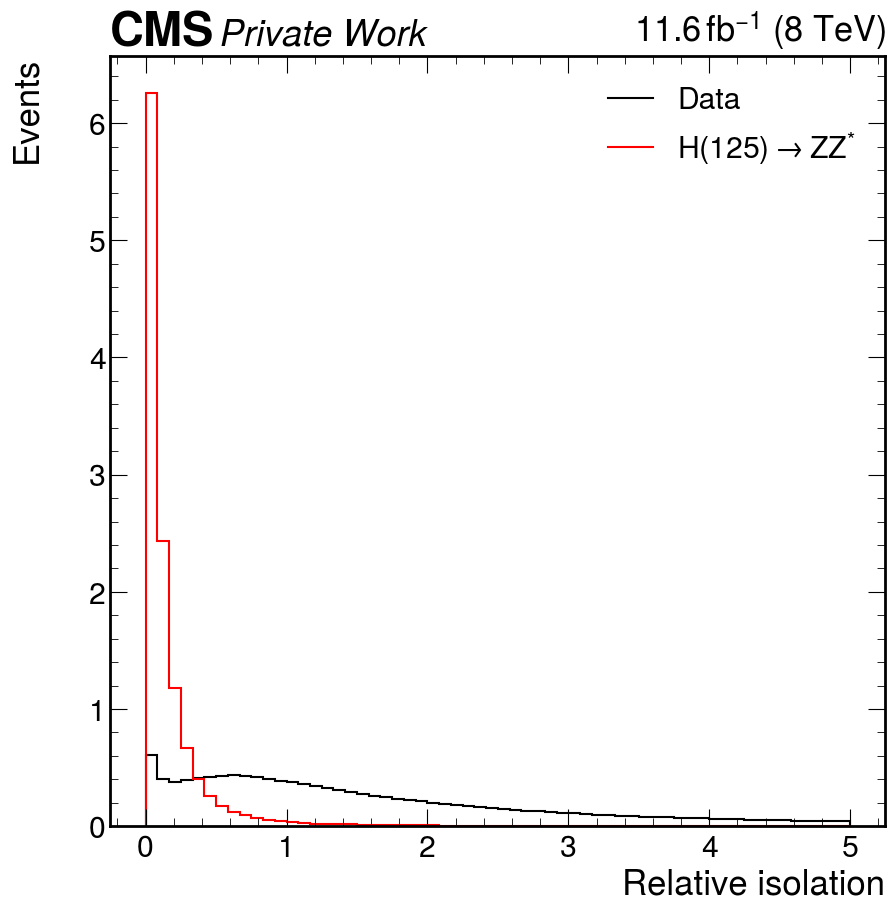

In [18]:
PlotShapeComparison(h_data["iso"], h_sig["iso"], r"Data", r"H(125)$ \rightarrow ZZ^{*}$", r"Relative isolation")

As we can see, the muons in data are predominantly having large isolation values. Let's run the analysis again, this time adding a cut on the muon relative isolation < 0.4 (by setting the `apply_muon_id` flag to `True`).

Running samples ['Run2012B_DoubleMuParked.root:Events', 'Run2012C_DoubleMuParked.root:Events']
Running samples ['ZZTo4mu.root:Events']
Running samples ['SMHiggsToZZTo4L.root:Events']


/var/folders/63/smjwcwgs2mvdq9xx4_7pt4th0000gp/T/ipykernel_17243/3046987690.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


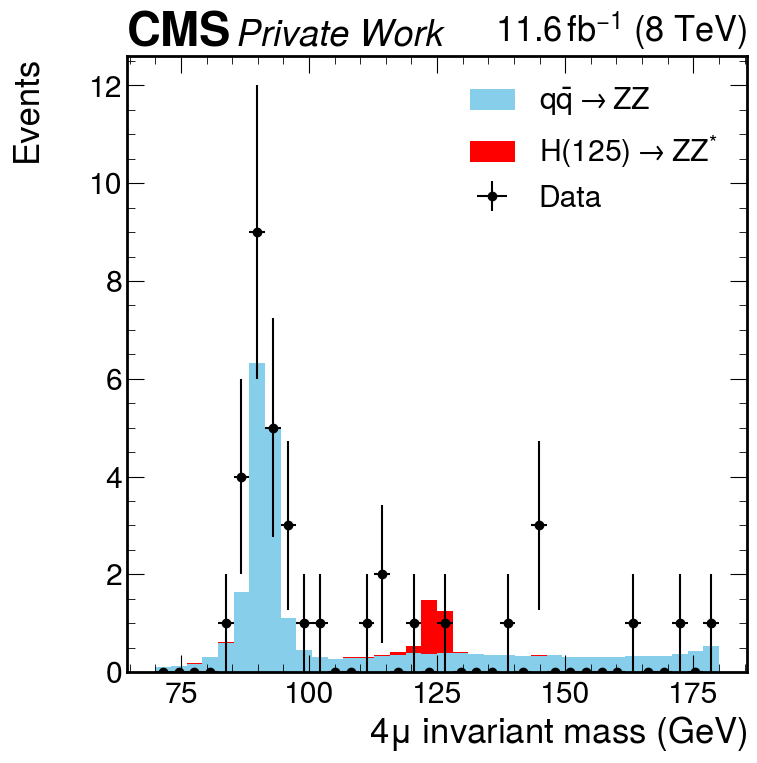

In [19]:
h_data = RunSamples(["Run2012B_DoubleMuParked.root:Events", "Run2012C_DoubleMuParked.root:Events"],
                    apply_muon_id=True, apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))
h_bkg = RunSamples(["ZZTo4mu.root:Events"],
                    apply_muon_id=True, apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))
h_sig = RunSamples(["SMHiggsToZZTo4L.root:Events"],
                    apply_muon_id=True, apply_Z_mass=True, z1range=(z1min, z1max), z2range=(z2min, z2max))

PlotDataSimComparison(h_data["m4l"], h_sig["m4l"], h_bkg["m4l"], scale_sig=scale_factor_sig, scale_bkg=scale_factor_bkg, logy=False)

That should look a lot better! We've suppressed the non-prompt background to a negligible level. We should see that the number of events surviving our cuts is relatively small, but the expected contribution from the signal is quite clearly visible. 

Question: So, do we have evidence for the Higgs boson based on the distribution above? More precisely, if we integrate the yields over the two bins where most of the signal is expected, with what probability would we see at least the number of observed events under the background-only hypothesis. We can assume the number of observed events follows a Poisson distribution.

Answer:

You should find that with the limited number of events we have here, the observation is quite compatible with both the signal+background and the background-only hypotheses, so we can't conclude the Higgs boson is present in our data. What could we do to improve the situation? Firstly, analyze more data - improve the statistical power of our measurement. Here we have only used a small fraction of the data delivered by the LHC. We should also consider Z boson decays to electron-positron pairs, and include the $ZZ \rightarrow 2e2\mu$ and $ZZ \rightarrow 4e$ channels (bonus question: what about $Z \rightarrow \tau\tau$ decays?). On top of that, we can also improve the signal-to-background ratio by further optimizing the analysis selection, and by constructing more powerful (multivariate) discriminators.

**Well done, you've reached the end of the exercise!**